<h1>Open TG-GATEs clinical pathology data from ChEMBL using web services</h1>

<h2>Introduction</h2>

Open TG-GATEs is a toxicogenomics database that stores gene expression profiles and traditional toxicological data derived from in vivo (rat) and in vitro (primary rat hepatocytes, primary human hepatocytes) exposure to 170 compounds at multiple dosages and time points. The toxicology data is composed of biochemistry, hematology and histopathology findings with pathology imaging from the in vivo studies and cytotoxicity from the in vitro studies. The 170 compounds include representative known liver- and kidney-injuring pharmaceuticals, compounds and chemicals.<sup>(1)</sup> The data can be browsed <a href='http://toxico.nibiohn.go.jp/open-tggates/english/search.html'>here</a>.

Biochemistry, hematology, organ weight and histopathology findings from the Open TG-GATEs dataset have been integrated into ChEMBL and can be found under src_id 11 and document_chembl_ids CHEMBL2766011 (biochemistry), CHEMBL2766014 (hematology), CHEMBL2766012 (organ weight) and CHEMBL2766013 (histopathology). Doses, time points, regimens and study_ids are stored in the assay description. For each biochemistry, hematology and organ weight endpoint, the average value across the individual animal samples has been calculated. The averaged treatment value is recorded as an activity standard_value while the  averaged controls for those endpoints can be found in the activity_comment.

Detailed information regarding how to use the ChEMBL web services can be found <a href='https://www.ebi.ac.uk/chembl/ws'>here</a>.

<sup>(1)</sup> Igarashi, Y., Nakatsu, N., Yamashita, T., Ono, A., Ohno, Y., Urushidani, T., & Yamada, H. (2015). Open TG-GATEs: a large-scale toxicogenomics database. Nucleic Acids Research, 43(Database issue), D921–7.



<h2>Configuration and setup</h2>

In [1]:
from chembl_webresource_client.new_client import new_client
from chembl_webresource_client.settings import Settings
Settings.Instance().MAX_LIMIT = 1000
import requests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('max_colwidth',300)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",150)

<h2> Retrieve Open TG-GATEs data from ChEMBL</h2>

Requests to ChEMBL can be made either by 

1\. Using the API provided by the Python package chembl_webresource_client:

In [2]:
activity = new_client.activity
activity.set_format('json')

tggates_act_api = activity.get(document_chembl_id=(['CHEMBL2766011', 'CHEMBL2766014', 'CHEMBL2766012', 'CHEMBL2766013']))

len(tggates_act_api)

158199

2\. Directly <i>via</i> URLs:

In [3]:
url_stem = "https://www.ebi.ac.uk"
tggates_url = requests.get(url_stem + "/chembl/api/data/activity.json?assay_description__icontains=TG-GATES&limit=1000").json()
tggates_act_url = tggates_url['activities']

while tggates_url['page_meta']['next']:
    tggates_url = requests.get(url_stem + tggates_url['page_meta']['next']).json()
    tggates_act_url += tggates_url['activities']

len(tggates_act_url)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

For simplicity, the retrieved data will be converted to a dataframe: 

In [4]:
tggates_act_api_list = list(tggates_act_api.all())

tggates_df = pd.DataFrame(tggates_act_api_list)

tggates_df.shape

(158199, 31)

As mentioned before, doses, time points, regimens and study_ids are stored in the assay description. For each biochemistry, hematology and organ weight endpoint, the average value across the individual animal samples has been calculated. The averaged treatment value is recorded as an activity standard_value while the averaged controls for those endpoints can be found in the activity_comment. Here is an example,

In [5]:
tggates_df.head(1)

,activity_comment,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,canonical_smiles,data_validity_comment,document_chembl_id,document_journal,document_year,molecule_chembl_id,pchembl_value,potential_duplicate,published_relation,published_type,published_units,published_value,qudt_units,record_id,src_id,standard_flag,standard_relation,standard_type,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,uo_units
0,SD=2.07; p-value=0.44; N=5 || Control_MEAN=141.60; Control_SD=1.82; Control_N=5,13518617,CHEMBL2810656,Open TG-GATES: Regimen: Single; Time: 6 hr; Dose: High; Route: Gavage | Dataset: Biochemistry; Assay: SODIUM (Sodium); Study_ID: 183/14,T,BAO_0000179,BAO_0000218,Cc1ccc(C)c(OCCCC(C)(C)C(=O)O)c1,None,CHEMBL2766011,None,None,CHEMBL457,None,False,None,SODIUM,meq/L,142.6,None,1933591,11,True,None,SODIUM,mEq.L-1,142.6,CHEMBL376,Rattus norvegicus,Rattus norvegicus,None


Open TG-GATEs data is now ready to be used.

Further processing of the data might be useful. In the next step, parameters such as dose_level, time, regimen, route, study_id were extracted from the assay_description. p-values and standard_values for the controls can also be extracted from the activity_comment for further comparison with the treatment standard_values.

In [6]:
# get fields of interest
tggates = tggates_df[['assay_chembl_id', 'assay_description', 'molecule_chembl_id', 'standard_type', 'standard_value', 'standard_units', 'activity_comment']]

tggates.shape

(158199, 7)

In [7]:
tggates.head(1)

,assay_chembl_id,assay_description,molecule_chembl_id,standard_type,standard_value,standard_units,activity_comment
0,CHEMBL2810656,Open TG-GATES: Regimen: Single; Time: 6 hr; Dose: High; Route: Gavage | Dataset: Biochemistry; Assay: SODIUM (Sodium); Study_ID: 183/14,CHEMBL457,SODIUM,142.6,mEq.L-1,SD=2.07; p-value=0.44; N=5 || Control_MEAN=141.60; Control_SD=1.82; Control_N=5


In [8]:
# filter on endpoints of interest, e.g. clinical chemistry and hematology data
h_cc = tggates[tggates['assay_description'].str.contains('Hematology', 'Biochemistry')]

h_cc.shape

(60540, 7)

In [9]:
# information regarding dose, time, regimen is store in assay_description
tggates_ap_split = h_cc['assay_description'].str.split(' \| |; ', 0, expand=True).add_prefix('assay_description_part')

tggates_ap_split.shape

(60540, 7)

In [10]:
tggates_ap_split.head(1)

,assay_description_part0,assay_description_part1,assay_description_part2,assay_description_part3,assay_description_part4,assay_description_part5,assay_description_part6
589,Open TG-GATES: Regimen: Single,Time: 6 hr,Dose: Low,Route: Gavage,Dataset: Hematology,Assay: RBC (Erythrocytes),Study_ID: 542/6


In [11]:
regimen    = tggates_ap_split['assay_description_part0'].str.split(':', 0,   expand=True).rename(columns={2:'regimen'}             ).drop([0,1], 1)
time       = tggates_ap_split['assay_description_part1'].str.split(':', 0,   expand=True).rename(columns={1:'time'}                ).drop([0],   1)
dose_level = tggates_ap_split['assay_description_part2'].str.split(':', 0,   expand=True).rename(columns={1:'dose_level'}          ).drop([0],   1)
route      = tggates_ap_split['assay_description_part3'].str.split(':', 0,   expand=True).rename(columns={1:'route'}               ).drop([0],   1)
dataset    = tggates_ap_split['assay_description_part4'].str.split(':', 0,   expand=True).rename(columns={1:'dataset'}             ).drop([0],   1)
assay_test = tggates_ap_split['assay_description_part5'].str.split(':', 0,   expand=True).rename(columns={1:'assay_test'}          ).drop([0],   1)
exp_group  = tggates_ap_split['assay_description_part6'].str.split(':|/', 0, expand=True).rename(columns={1:'exp_id', 2:'group_id'}).drop([0],   1)

In [12]:
regimen.head(1)

,regimen
589,Single


In [13]:
exp_group.head(1)

,exp_id,group_id
589,542,6


In [14]:
tggates_ap = (
    regimen
    .merge(time,       left_index=True, right_index=True, how='inner')
    .merge(dose_level, left_index=True, right_index=True, how='inner')
    .merge(route,      left_index=True, right_index=True, how='inner')
    .merge(dataset,    left_index=True, right_index=True, how='inner')
    .merge(assay_test, left_index=True, right_index=True, how='inner')
    .merge(exp_group,  left_index=True, right_index=True, how='inner')
)

In [15]:
tggates_ap.shape

(60540, 8)

In [16]:
tggates_ap.head(1)

,regimen,time,dose_level,route,dataset,assay_test,exp_id,group_id
589,Single,6 hr,Low,Gavage,Hematology,RBC (Erythrocytes),542,6


In [17]:
tggates_ap = tggates_ap.replace('^\s', '', regex=True)

In [18]:
# information regarding treatment and control is store in activity_comment:
tggates_split = h_cc['activity_comment'].str.split(' \|\| ', expand=True).add_prefix('act_comment_part')

tggates_split.shape

(60540, 2)

In [19]:
tggates_split.head(1)

,act_comment_part0,act_comment_part1
589,SD=26.81; p-value=0.81; N=5,Control_MEAN=643.60; Control_SD=39.44; Control_N=5


In [20]:
tggates_treat   = tggates_split['act_comment_part0'].str.split(';', expand=True).add_prefix('treatment_part')
tggates_control = tggates_split['act_comment_part1'].str.split(';', expand=True).add_prefix('control_part')

tggates_treat.shape, tggates_control.shape

((60540, 3), (60540, 3))

In [21]:
tggates_treat.head(1)

,treatment_part0,treatment_part1,treatment_part2
589,SD=26.81,p-value=0.81,N=5


In [22]:
t_sd_t = tggates_treat['treatment_part0'].str.split('=', expand=True).rename(columns={1:'SD'}).drop([0], 1)
t_sd_t.fillna(value=np.nan, inplace=True)
t_sd_t['SD'] = t_sd_t['SD'].map(lambda x: x.strip()).replace('nan', np.nan)

t_sd_t.shape

(60540, 1)

In [23]:
t_sd_t.head(1)

,SD
589,26.81


In [24]:
t_p_t = tggates_treat['treatment_part1'].str.split('=', expand=True).rename(columns={1:'p-value'}).drop([0], 1)
t_p_t.fillna(value=np.nan, inplace=True)

t_p_t.shape

(60540, 1)

In [25]:
t_p_t.head(1)

,p-value
589,0.81


In [26]:
t_n_t = tggates_treat['treatment_part2'].str.split('=', expand=True).rename(columns={1:'N'}).drop([0], 1)
t_n_t.fillna(value=np.nan, inplace=True)

t_n_t.shape

(60540, 1)

In [27]:
t_n_t.head(1)

,N
589,5


In [28]:
tggates_control.head(1)

,control_part0,control_part1,control_part2
589,Control_MEAN=643.60,Control_SD=39.44,Control_N=5


In [29]:
t_mean_c = tggates_control['control_part0'].str.split('=', expand=True).rename(columns={1:'control_value'}).drop([0], 1)
t_mean_c.fillna(value=np.nan, inplace=True)

t_mean_c.shape

(60540, 1)

In [30]:
t_mean_c.head(1)

,control_value
589,643.60


In [31]:
t_sd_c = tggates_control['control_part1'].str.split('=', 0, expand=True).rename(columns={1:'control_SD'}).drop([0], 1)
t_sd_c.fillna(value=np.nan, inplace=True)

t_sd_c.shape

(60540, 1)

In [32]:
t_sd_c.head(1)

,control_SD
589,39.44


In [33]:
t_n_c = tggates_control['control_part2'].str.split('=', 0, expand=True).rename(columns={1:'control_N'}).drop([0], 1)
t_n_c.fillna(value=np.nan, inplace=True)

t_n_c.shape

(60540, 1)

In [34]:
t_n_c.head(1)

,control_N
589,5


In [35]:
tggates_comment = (
    t_sd_t[['SD']]
    .merge(t_p_t.loc[:,   ['p-value']],       left_index=True, right_index=True, how='inner')
    .merge(t_n_t.loc[:,   ['N']],             left_index=True, right_index=True, how='inner')
    .merge(t_mean_c.loc[:,['control_value']], left_index=True, right_index=True, how='inner')
    .merge(t_sd_c.loc[:,  ['control_SD']],    left_index=True, right_index=True, how='inner')
    .merge(t_n_c.loc[: ,  ['control_N']],     left_index=True, right_index=True, how='inner')
)

tggates_comment.shape

(60540, 6)

In [36]:
tggates_comment.head(1)

,SD,p-value,N,control_value,control_SD,control_N
589,26.81,0.81,5,643.60,39.44,5


In [37]:
# merge the assay parameters, with the activity data for treatment and control assays
tggates_f = (
    tggates_ap
    .merge(h_cc,            left_index=True, right_index=True, how='inner')
    .merge(tggates_comment, left_index=True, right_index=True, how='inner')
)

tggates_f.shape

(60540, 21)

In [38]:
tggates_f.head(1)

,regimen,time,dose_level,route,dataset,assay_test,exp_id,group_id,assay_chembl_id,assay_description,molecule_chembl_id,standard_type,standard_value,standard_units,activity_comment,SD,p-value,N,control_value,control_SD,control_N
589,Single,6 hr,Low,Gavage,Hematology,RBC (Erythrocytes),542,6,CHEMBL2884443,Open TG-GATES: Regimen: Single; Time: 6 hr; Dose: Low; Route: Gavage | Dataset: Hematology; Assay: RBC (Erythrocytes); Study_ID: 542/6,CHEMBL1697830,RBC,6382000,cells.uL-1,SD=26.81; p-value=0.81; N=5 || Control_MEAN=643.60; Control_SD=39.44; Control_N=5,26.81,0.81,5,643.60,39.44,5


In [39]:
# reorder columns and select fields of interest
tggates_f = tggates_f[['molecule_chembl_id', 'dataset', 'assay_chembl_id', 'assay_test', 'regimen', 'dose_level', 'time', 'route', 'exp_id', 'group_id', 'standard_type', 'standard_value', 'standard_units', 'SD', 'p-value', 'N', 'control_value', 'control_SD', 'control_N']]

tggates_f.head(1)

,molecule_chembl_id,dataset,assay_chembl_id,assay_test,regimen,dose_level,time,route,exp_id,group_id,standard_type,standard_value,standard_units,SD,p-value,N,control_value,control_SD,control_N
589,CHEMBL1697830,Hematology,CHEMBL2884443,RBC (Erythrocytes),Single,Low,6 hr,Gavage,542,6,RBC,6382000,cells.uL-1,26.81,0.81,5,643.60,39.44,5


<h1>Tox Flag</h1>

We are always interested in understanding how these datasets are used by our collaborators.
<br>For these type of data, we believe it would be useful to the user to have a simple flag that could summarise the observations across treatment and controls.</br>

Here we propose a way of providing this summary based on very simple and intuitive rules:

For each study and endpoint, a tox_flag is calculated based on comparisons between 

1\. the treatment values and the controls:
<br>- if there's a significant difference between treatment values and controls (p-value <= 0.05) and there's an increase above controls: tox_flag = 0.5</br>
<br>- if there's a significant difference between treatment values and controls (p-value <= 0.05) and there's a decrease below controls: tox_flag = -0.5</br>

2\. the treatment_values and normal ranges of historical controls
<br>- if there's a significant difference between treatment values and controls (p-value <= 0.05) and there's an increase above the normal range: tox_flag = 1</br>
<br>- if there's a significant difference between treatment values and controls (p-value <= 0.05) and there's a decrease below the normal range: tox_flag = -1</br>

Normal ranges available in the DrugMatrix<sup>2</sup> <i>in vivo</i> dataset were used as reference. The DrugMatrix dataset can also be found in CHEMBL under src_id 15 and document_chembl_ids CHEMBL2924216 (biochemistry), CHEMBL2924217 (hematology) and CHEMBL2924218 (pathology).

<sup>2</sup>Ganter, B., Tugendreich, S., Pearson, C. I., Ayanoglu, E., Baumhueter, S., Bostian, K. A., et al. (2005). Development of a large-scale chemogenomics database to improve drug candidate selection and to understand mechanisms of chemical toxicity and action. Journal of Biotechnology, 119(3), 219–244.

In [40]:
# define how to calculate tox_flag
def tox_flag(row):
    if (float(row['standard_value']) > float(row['control_value'])) & (float(row['standard_value']) > float(row['nrange_uvalue'])) & (float(row['p-value']) <= 0.05) & (pd.isnull(row['standard_value']) != True) & (pd.isnull(row['control_value']) != True) & (pd.isnull(row['p-value']) != True):
        val = 1
    elif (float(row['standard_value']) > float(row['control_value'])) & (float(row['standard_value']) <= float(row['nrange_uvalue'])) & (float(row['p-value']) <= 0.05) & (pd.isnull(row['standard_value']) != True) & (pd.isnull(row['control_value']) != True) & (pd.isnull(row['p-value']) != True):
        val = 0.5
    elif (float(row['standard_value']) > float(row['control_value'])) & (float(row['p-value']) > 0.05) & (pd.isnull(row['standard_value']) != True) & (pd.isnull(row['control_value']) != True) & (pd.isnull(row['p-value']) != True):
        val = 0
    elif (float(row['standard_value']) < float(row['control_value'])) & (float(row['p-value']) <= 0.05) & (float(row['standard_value']) < float(row['nrange_lvalue'])) & (pd.isnull(row['standard_value']) != True) & (pd.isnull(row['control_value']) != True) & (pd.isnull(row['p-value']) != True):
        val = -1
    elif (float(row['standard_value']) < float(row['control_value'])) & (float(row['p-value']) <= 0.05) & (float(row['standard_value']) >= float(row['nrange_lvalue'])) & (pd.isnull(row['standard_value']) != True) & (pd.isnull(row['control_value']) != True) & (pd.isnull(row['p-value']) != True):
        val = -0.5
    elif (float(row['standard_value']) < float(row['control_value'])) & (float(row['p-value']) > 0.05) & (pd.isnull(row['standard_value']) != True) & (pd.isnull(row['control_value']) != True) & (pd.isnull(row['p-value']) != True):
        val = 0
    elif (float(row['standard_value']) == float(row['control_value'])) & (pd.isnull(row['standard_value']) != True) & (pd.isnull(row['control_value']) != True):
        val = 0
    else:
        val = 0
    return val

In [41]:
# retrieve normal ranges from the drugmatrix data in ChEMBL for the biochemistry and hematology endpoints
drugmatrix_act_api      = activity.get(document_chembl_id=(['CHEMBL2924216', 'CHEMBL2924217']))
drugmatrix_act_api_list = list(drugmatrix_act_api.all())
drugmatrix_df           = pd.DataFrame(drugmatrix_act_api_list)
dmatrix                 = drugmatrix_df[['standard_type', 'activity_comment']]

# extract normal range from activity_comment
dmatrix_split  = dmatrix['activity_comment'].str.split('\ \|\|\ ', 0, expand=True).add_prefix('act_comment_part')
dmatrix_nrange = dmatrix_split['act_comment_part2'].str.split(':', 0, expand=True).add_prefix('nrange_part')
nrange         = dmatrix_nrange['nrange_part1'].str.split('-', 0, expand=True).rename(columns={0: 'nrange_lvalue',1:'nrange_uvalue'})

# for each endpoint, merge upper and lower values for the normal range
dmatrix.drop('activity_comment', axis=1, inplace=True)
dmatrix_nrange = dmatrix.merge(nrange, left_index = True, right_index = True, how='inner').drop_duplicates()

In [42]:
dmatrix_nrange.head(1)

,standard_type,nrange_lvalue,nrange_uvalue
0,ALT,29,75


In [43]:
# merge dmatrix_nrange to tggates_all
tggates_all = tggates_f.merge(dmatrix_nrange, on='standard_type', how='inner')

tggates_all.head(1)

,molecule_chembl_id,dataset,assay_chembl_id,assay_test,regimen,dose_level,time,route,exp_id,group_id,standard_type,standard_value,standard_units,SD,p-value,N,control_value,control_SD,control_N,nrange_lvalue,nrange_uvalue
0,CHEMBL1697830,Hematology,CHEMBL2884443,RBC (Erythrocytes),Single,Low,6 hr,Gavage,542,6,RBC,6382000,cells.uL-1,26.81,0.81,5,643.60,39.44,5,4.92,7.53


In [44]:
# calculate tox_flag
tggates_all['tox_flag'] = tggates_all.apply(tox_flag, axis=1)

tggates_all.head(1)

,molecule_chembl_id,dataset,assay_chembl_id,assay_test,regimen,dose_level,time,route,exp_id,group_id,standard_type,standard_value,standard_units,SD,p-value,N,control_value,control_SD,control_N,nrange_lvalue,nrange_uvalue,tox_flag
0,CHEMBL1697830,Hematology,CHEMBL2884443,RBC (Erythrocytes),Single,Low,6 hr,Gavage,542,6,RBC,6382000,cells.uL-1,26.81,0.81,5,643.60,39.44,5,4.92,7.53,0.0


In [87]:
# format time and dose_level to be used to sort data

tggates_all_sorted = tggates_all.copy()
tggates_all_sorted['time_day'] = np.where(tggates_all_sorted['time'].str.split(' ').str[1] =='hr', round(tggates_all_sorted['time'].str.split(' ').str[0].astype(int)/int(24), 2),tggates_all_sorted['time'].str.split(' ').str[0].astype(int))
tggates_all_sorted['dose_level'] = np.where((tggates_all_sorted['dose_level']== 'Low') & (tggates_all_sorted['dose_level']!= '2_Middle') & (tggates_all_sorted['dose_level']!= '3_High'), '1_Low', tggates_all_sorted['dose_level'])
tggates_all_sorted['dose_level'] = np.where((tggates_all_sorted['dose_level']== 'Middle') & (tggates_all_sorted['dose_level']!= '1_Low') & (tggates_all_sorted['dose_level']!= '3_High'), '2_Middle', tggates_all_sorted['dose_level'])
tggates_all_sorted['dose_level'] = np.where((tggates_all_sorted['dose_level']== 'High') & (tggates_all_sorted['dose_level']!= '1_Low') & (tggates_all_sorted['dose_level']!= '2_Middle'), '3_High', tggates_all_sorted['dose_level'])
tggates_all_sorted.drop(['time'], axis = 1, inplace=True)

tggates_all_sorted.head(1)

,molecule_chembl_id,dataset,assay_chembl_id,assay_test,regimen,dose_level,route,exp_id,group_id,standard_type,standard_value,standard_units,SD,p-value,N,control_value,control_SD,control_N,nrange_lvalue,nrange_uvalue,tox_flag,time_day
0,CHEMBL1697830,Hematology,CHEMBL2884443,RBC (Erythrocytes),Single,1_Low,Gavage,542,6,RBC,6382000,cells.uL-1,26.81,0.81,5,643.60,39.44,5,4.92,7.53,0.0,0.25


In [89]:
# for clear visualisation, build matrix with rows of compounds and time points and columns of end poinst and dose_levels
tggates_all_sorted_pv = pd.pivot_table(tggates_all_sorted, index=['molecule_chembl_id','time_day'], columns=['standard_type', 'dose_level'], values='tox_flag')

tggates_all_sorted_pv.head(8)

standard_type               BASOLE                 EOSLE                  \
dose_level                   1_Low 2_Middle 3_High 1_Low 2_Middle 3_High   
molecule_chembl_id time_day                                                
CHEMBL101          0.12        0.0      0.0    0.0   0.0      0.0    0.0   
                   0.25        0.0      0.0    0.0   0.0      0.0    0.0   
                   0.38        0.0      0.0    0.0   0.0      0.0    0.0   
                   1.00        0.0      0.0    0.0   0.0      0.0    0.0   
                   4.00        0.0      0.0    0.0   0.0      0.0    0.0   
                   8.00        0.0      0.0    0.0   0.0      0.0    0.0   
                   15.00       0.0      0.0    0.0   0.0      0.0    0.0   
                   29.00       0.0      0.0    0.0   0.0      0.0    0.0   

standard_type                 HCT                   HGB                 LYMLE  \
dose_level                  1_Low 2_Middle 3_High 1_Low 2_Middle 3_High 1_Low   
molecule_chembl_id time_day                                                     
CHEMBL101          0.12       0.0      0.0    0.0   0.0      0.0    0.0   0.0   
                   0.25       0.0      0.0    0.0   0.0      0.0    0.0  -0.5   
                   0.38       0.0      0.5    0.5   0.0      1.0    1.0   0.0   
                   1.00       0.0      0.0    0.0   0.0      0.0    0.0   0.0   
                   4.00       0.0      0.0    0.0   0.0      0.0    0.0   0.0   
                   8.00       0.0      0.0   -0.5   0.0      0.0    0.0   0.0   
                   15.00      0.0      0.0   -0.5   0.0      0.0    1.0   0.0   
                   29.00      0.0      0.0   -0.5   0.0      0.0    1.0   0.0   

standard_type                                 MCH                  MCHC  \
dose_level                  2_Middle 3_High 1_Low 2_Middle 3_High 1_Low   
molecule_chembl_id time_day                                               
CHEMBL101          0.12          0.0    0.0   0.0      0.0    0.0   0.0   
                   0.25          0.0   -0.5   0.0      0.0    0.0   0.0   
                   0.38          0.0    0.0   0.0      0.0    0.0   0.0   
                   1.00          0.0   -1.0   0.0      0.0    0.0   0.0   
                   4.00          0.0    0.0   0.0      0.0    0.0   0.0   
                   8.00          0.0   -0.5   0.0      0.0    0.0   0.0   
                   15.00         0.0   -0.5   0.0      0.0    0.0   0.0   
                   29.00         0.0    0.0   0.5      0.5    0.5   0.0   

standard_type                                 MCV                 MONOLE  \
dose_level                  2_Middle 3_High 1_Low 2_Middle 3_High  1_Low   
molecule_chembl_id time_day                                                
CHEMBL101          0.12          0.0   -0.5   0.0      0.0    0.0    1.0   
                   0.25          0.0    0.0   0.0      0.0    0.0    0.0   
                   0.38          0.0    0.0   0.0      0.0    0.0    0.0   
                   1.00          0.0    0.0   0.0      0.0    0.0    0.0   
                   4.00          0.0    0.0   0.0      0.0    0.0    0.0   
                   8.00          0.5    0.0   0.0      0.0    0.0    0.0   
                   15.00         0.0    0.0   0.0      0.0   -0.5    0.0   
                   29.00         0.0    0.0   0.5      0.5    0.5    0.0   

standard_type                               NEUTLE                  PLAT  \
dose_level                  2_Middle 3_High  1_Low 2_Middle 3_High 1_Low   
molecule_chembl_id time_day                                                
CHEMBL101          0.12          0.0    0.0    0.0      0.0    0.0   0.0   
                   0.25          0.0    0.0    0.5      0.0    0.0   0.0   
                   0.38          0.0    0.0    0.0      0.0    0.0   0.0   
                   1.00          0.0    0.0    0.0      0.0    0.5   0.0   
                   4.00          0.0    0.0    0.0      0.0    0.0   0.0   


Note that Open TG-GATEs gene expression profiles can be found in <a href='https://www.ebi.ac.uk/arrayexpress/search.html?query=Open+TG-GATEs'>ArrayExpress</a> and be linked to the Open TG-GATEs clinical pathology studies in ChEMBL.
<br>Taking as an example the experiment <a href='https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-800/?query=Open+TG-GATEs'>E-MTAB-800</a> from ArrayExpress,

1\. the 'Term Accession Number' in E-MTAB-800 corresponds to the molecule_chembl_id
<br>2\. the 'Source Name' in E-MTAB-800 has some correspondance to the exp_id and group_id. For example, the source name 182051 in E-MTAB-800 corresponds to exp_id = 182 and group_id = 5 (study_id = 182/5). The last digit in the source name refers to the animal_id.</br>


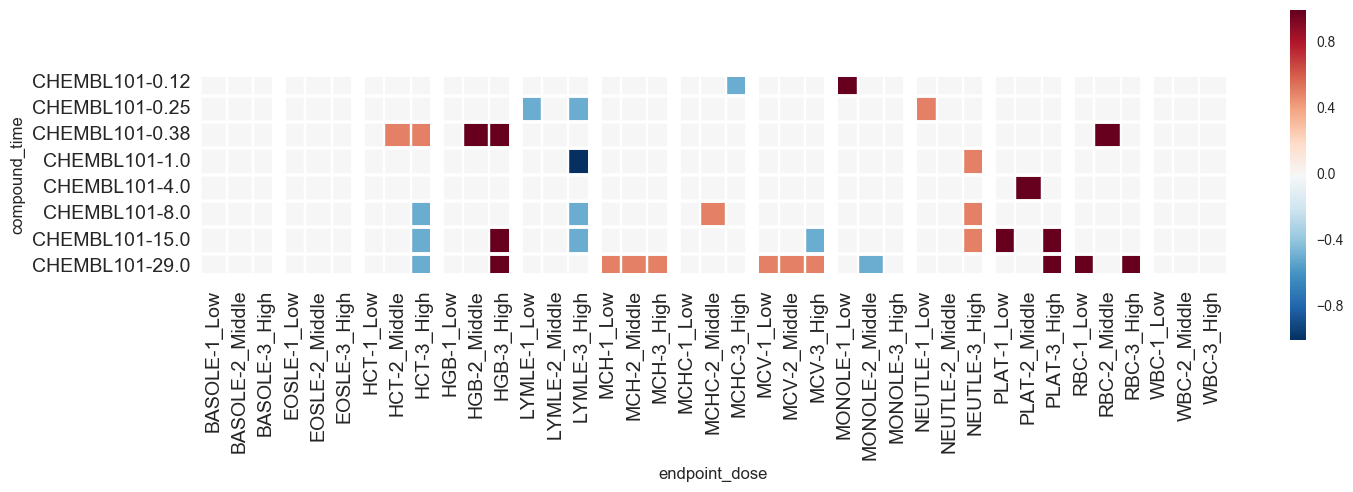

In [91]:
# plot heatmap using seaborn

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

f, ax = plt.subplots(figsize=(15, 5))

sns.heatmap(tggates_all_sorted_pv.head(8), vmax=.8, square=True)

compounds = tggates_all_sorted_pv.head(8).index.get_level_values("molecule_chembl_id")
endpoints = tggates_all_sorted_pv.head(8).columns.get_level_values("standard_type")
doses = tggates_all_sorted_pv.head(8).columns.get_level_values("dose_level")
for j, compound in enumerate(compounds):
    for i, endpoint in enumerate(endpoints):
        if i and endpoint != endpoints[i - 1]:
            for z, doses in enumerate(doses):
                ax.axhline(j, c="w")
                ax.axhline(j*8, c="w",linewidth=10)
                ax.axvline(i, c="w",linewidth=10)
                ax.axvline(z, c="w")
                ax.set_xlabel("endpoint_dose", fontsize=12)
                ax.set_ylabel("compound_time", fontsize=12)
                ax.tick_params(axis='x', labelsize=14)
                ax.tick_params(axis='y', labelsize=14)
            f.tight_layout()